In [101]:
# import libaries
import requests
import base64

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns



import os
from dotenv import load_dotenv

In [67]:
#functions to get tracks from spotify

def get_access_token(id: str, secret: str):
    token_url = 'https://accounts.spotify.com/api/token'
    credentials = f'{id}:{secret}'
    encoded_credentials = base64.b64encode(credentials.encode('utf-8')).decode('utf-8')

    headers = {
        'Authorization': f'Basic {encoded_credentials}',
        'Content-type': 'application/x-www-form-urlencoded',
    }

    data = {
        'grant_type': 'client_credentials'
    }

    print("getting access token from spotify")
    response = requests.post(token_url, headers=headers, data=data)
    if response.status_code == 200:

        print("fetched token successfully, token:",response.json()['access_token'])

        return response.json()['access_token']

    else:
        raise Exception('Failed to retrieve access token')

def get_playlist_tracks(playlist_id, token):
    all_tracks = []
    limit = 100
    offset = 0
    url = f'https://api.spotify.com/v1/playlists/{playlist_id}/tracks'
    headers = {
        'Authorization': f'Bearer {token}',
    }

    print("getting playlists from spotify")
    while True:
        params = {
            'limit': limit,
            'offset': offset,
        }
        response = requests.get(url, headers=headers, params=params)

        if response.status_code == 200:
            print("fetched playlists from spotify succesfully")
            data = response.json()
            all_tracks.extend([item['track'] for item in data['items']])

            if len(data['items']) < limit:
                break
            else:
                offset += limit
        else:
            raise Exception(f"Failed to retrieve tracks: {response.status_code}")
    return all_tracks




def get_audio_features_for_tracks(playlists_ids, token):
    url = f'https://api.spotify.com/v1/audio-features'
    headers = {
        'Authorization': f'Bearer {token}',
    }

    params = {
        'ids': ','.join(playlists_ids)
    }

    print("getting audio features from spotify")
    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        print("fetched audio features from spotify")
        return response.json()['audio_features']
    else:
        raise Exception(f"Failed to retrieve audio features: {response.status_code}")


def get_playlist_audio_features(playlists, token):

    audio_features = []
    for i in range(0, len(playlists), 100):
        batch_track_ids = [playlist["id"] for playlist in playlists[i:i+100]]
        features = get_audio_features_for_tracks(batch_track_ids, token)
        audio_features.extend(features)

    return audio_features



In [68]:
# the function to get recommendations based on some tracks, target audio features (if any)
# this will be used to benchmark results

def get_recommendations(seed_tracks, target_audio_features, token):
    url = 'https://api.spotify.com/v1/recommendations'
    headers = {
        "Authorization": f'Bearer {token}'
    }

    params = {
        'seed_tracks': ','.join(seed_tracks),
        'limit': 10,
    }

    if target_audio_features['danceability'] != None:
        params['target_danceability'] = target_audio_features['danceability']
    if target_audio_features['energy'] != None:
        params['target_energy'] = target_audio_features['energy']
    if target_audio_features['valence'] != None:
        params['target_valence'] = target_audio_features['valence']
    if target_audio_features['tempo'] != None:
        params['target_tempo'] = target_audio_features['tempo']
    if target_audio_features['loudness'] != None:
        params['target_loudness'] = target_audio_features['loudness']
    if target_audio_features['speechiness'] != None:
        params['target_speechiness'] = target_audio_features['speechiness']
    if target_audio_features['acousticness'] != None:
        params['target_acousticness'] = target_audio_features['acousticness']
    if target_audio_features['instrumentalness'] != None:
        params['target_instrumentalness'] = target_audio_features['instrumentalness']
    if target_audio_features['liveness'] != None:
        params['target_liveness'] = target_audio_features['liveness']

    print("getting recommendations from spotify API")
    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        print("fetched recommendations successfully")
        return response.json()['tracks']
    else:
        raise Exception(f"failed to get recommendations: {response.status_code}")

In [69]:
# functions to manipulate dataset

def preprocess_features(audio_features_df):
    #scale the the selected audio features so they have a mean of 0 and sd of 1
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(audio_features_df)

    return pd.DataFrame(scaled_features, columns=audio_features_df.columns)

def extract_artists_name(artists):
    return ', '.join([artist['name'] for artist in artists])
    # return artists[0]['name'] ### works if there is only 1 artist

In [70]:
# get id and secret from .env file, then request token from spotify api
load_dotenv()
id = os.getenv('API_ID')
secret = os.getenv('API_SECRET')
print(id)
print(secret)


token = get_access_token(id, secret)

a92443ccaafd4f6790058418cc77ab4e
197bfdc600b14f4497c93263eb973948
getting access token from spotify
fetched token successfully, token: BQCbNSpVG3fUhqQqmUR2vWBCCjic8Rmnd6F3b15_26lx0cvsHFqH_YD7qhnhCgeFQTN_el1e-wLOOHFtGpBLEAfPxXY18khwAQMEHTvgTWZ1Jj7rw0I


In [105]:
#import dataset and show some rows of dataset
dataset = pd.read_csv("dataset.csv")

dataset.head()

'Ingrid Michaelson;ZAYN'

In [72]:
#columns of dataset
dataset.columns

Index(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre'],
      dtype='object')

In [73]:
#list of unique track genre in the dataset
print(dataset['track_genre'].unique().size)
dataset['track_genre'].unique()

114


array(['acoustic', 'afrobeat', 'alt-rock', 'alternative', 'ambient',
       'anime', 'black-metal', 'bluegrass', 'blues', 'brazil',
       'breakbeat', 'british', 'cantopop', 'chicago-house', 'children',
       'chill', 'classical', 'club', 'comedy', 'country', 'dance',
       'dancehall', 'death-metal', 'deep-house', 'detroit-techno',
       'disco', 'disney', 'drum-and-bass', 'dub', 'dubstep', 'edm',
       'electro', 'electronic', 'emo', 'folk', 'forro', 'french', 'funk',
       'garage', 'german', 'gospel', 'goth', 'grindcore', 'groove',
       'grunge', 'guitar', 'happy', 'hard-rock', 'hardcore', 'hardstyle',
       'heavy-metal', 'hip-hop', 'honky-tonk', 'house', 'idm', 'indian',
       'indie-pop', 'indie', 'industrial', 'iranian', 'j-dance', 'j-idol',
       'j-pop', 'j-rock', 'jazz', 'k-pop', 'kids', 'latin', 'latino',
       'malay', 'mandopop', 'metal', 'metalcore', 'minimal-techno', 'mpb',
       'new-age', 'opera', 'pagode', 'party', 'piano', 'pop-film', 'pop',
       'pow

In [121]:
#extract the key features from the dataset, then split into train and test datasets (using 'track_genre' as the label)
features_df = dataset[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]
features_df = preprocess_features(features_df)

X_train, X_test, y_train, y_test = train_test_split(features_df, dataset['track_genre'], test_size=0.2, random_state=42)
X_train

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
84744,0.421801,-0.192355,-0.478005,-0.426098,0.243864,-0.424320,-0.807098,0.208022,-0.825398
89295,1.545452,0.304607,0.524716,-0.144253,-0.267382,-0.504105,-0.554442,-0.181548,-1.004729
66688,1.263099,-1.655413,-1.641782,4.618737,1.094937,-0.504112,-0.065937,0.709449,-0.403023
51391,0.819401,0.745910,0.485545,1.516552,-0.737126,-0.504112,1.825049,0.694021,0.527258
95123,1.263099,0.240996,0.301624,-0.369350,0.589706,-0.504112,-0.491409,0.856020,-0.604370
...,...,...,...,...,...,...,...,...,...
76820,-0.073758,-2.519612,-4.435404,-0.325844,1.804666,-0.500978,0.039118,-1.226831,-0.088259
110268,0.704154,-0.347408,0.011723,-0.082776,-0.673371,2.448528,-0.666325,-1.199832,0.862436
103694,0.358416,-0.323554,-0.635482,-0.305983,0.842322,-0.504112,-0.165739,1.565733,-0.108507
860,-0.840146,-2.124546,-1.378327,-0.483791,1.903908,-0.504112,-0.658971,-1.373402,-0.598099


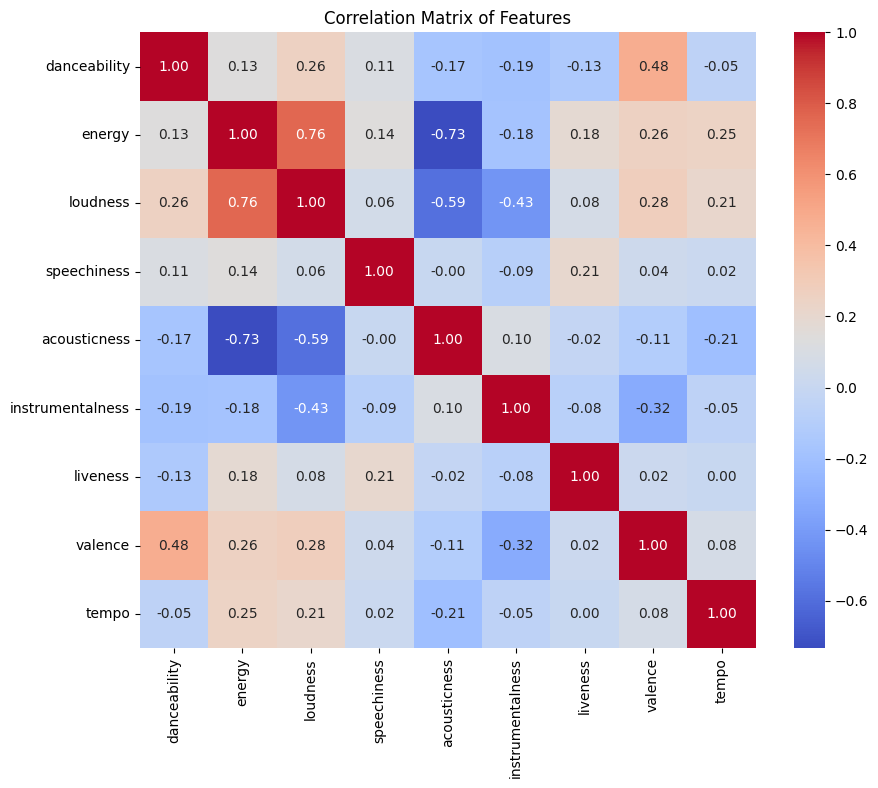

In [123]:
# Correlation matrix
correlation_matrix = features_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Features')
plt.show()


k=  1
accuracy=  0.17030701754385966
k=  2
accuracy=  0.15780701754385965
k=  3
accuracy=  0.15311403508771929
k=  4
accuracy=  0.15456140350877193
k=  5
accuracy=  0.15736842105263157
k=  6
accuracy=  0.15793859649122807
k=  7
accuracy=  0.16105263157894736
k=  8
accuracy=  0.16109649122807018
k=  9
accuracy=  0.16096491228070176
k=  10
accuracy=  0.1618859649122807
k=  11
accuracy=  0.1617543859649123
k=  12
accuracy=  0.1607017543859649
k=  13
accuracy=  0.1612719298245614
k=  14
accuracy=  0.16179824561403508
k=  15
accuracy=  0.16285087719298247
k=  16
accuracy=  0.16214912280701754
k=  17
accuracy=  0.16140350877192983
k=  18
accuracy=  0.1612280701754386
k=  19
accuracy=  0.161359649122807
k=  20
accuracy=  0.16144736842105264


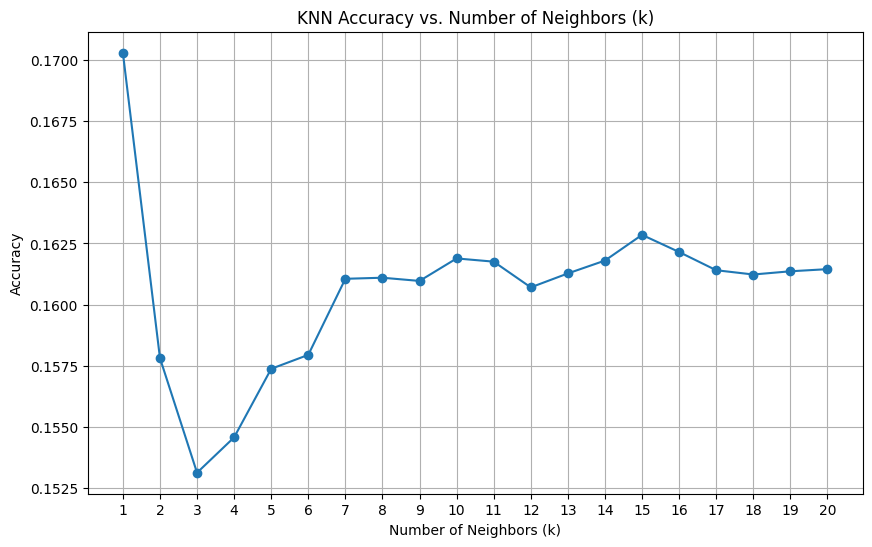

In [99]:
# check the model for the best k to be used in KNN model and plot the graph to visualize
# after finishing, we will use the k with the best accuracy for our model

#range of k values to test
k_values = range(1, 21)  #testing from 1 to 20
accuracies = []
best_k = 1
best_accuracy = 0

for k in k_values:  
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k
    print("k= ", k)
    print("accuracy= ", accuracy)

plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o')
plt.title('KNN Accuracy vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid()
plt.show()

In [75]:
#training the model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

Accuracy: 16.35%
Confusion Matrix:
 [[40  4  7 ...  0  0  0]
 [ 3 50  5 ...  3  1  0]
 [ 2  1 23 ...  0  0  1]
 ...
 [ 4  9  5 ...  8  0  0]
 [ 2  3  7 ...  0  1  0]
 [ 4  1 15 ...  0  0 23]]


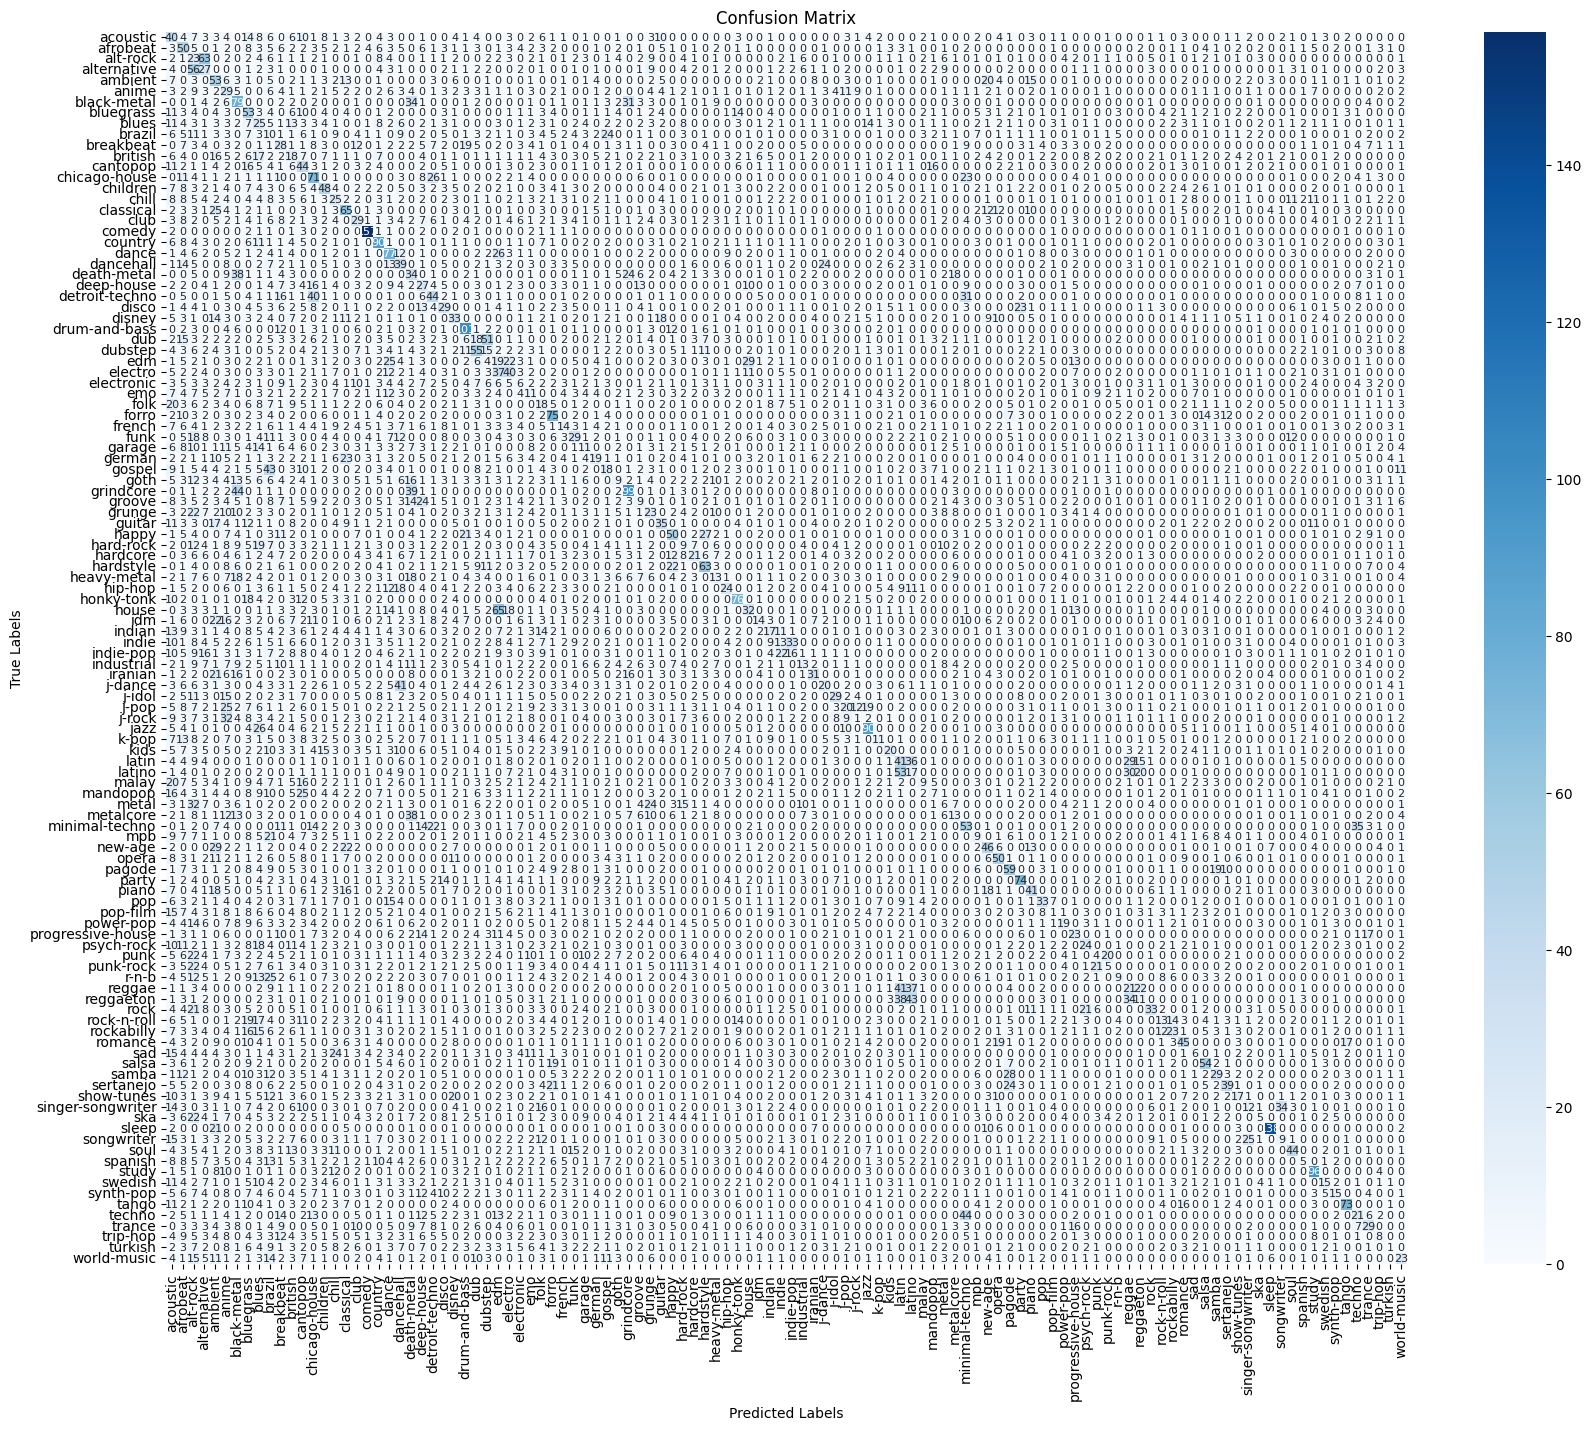

In [90]:
#test the model and check the accuracy
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

#generate confusion matrix and plot it
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)
plt.figure(figsize=(20, 16))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), annot_kws={"size": 8})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()